
# E4 Preprocessing and data modelling

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Signal processing stuff
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.stats as stats
# Machine learning stuff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Hampel filter from sktime
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer
import math
import os


In [3]:
# Definitions
dataset_dir = 'original_dataset/'
os.chdir("E:\Projects\Oulu\Data Mining Project\DataMiningProject")
PERSONS = 17
acceleration_data_loc = dataset_dir + 'P{:02d}/E4/ACC.csv'
VO2_data_loc = dataset_dir + 'P{:02d}/VO2/DataAverage.csv'
# Exercise lasts for 30 minutes
duration_of_exercise = 30 * 60 + 2
WINDOW_SIZE = 320

In [4]:
def load_acc_data(person):
    data = pd.read_csv(acceleration_data_loc.format(person))
    return data
def load_vo2_avg_data(person):
    data = pd.read_pickle(f"preprocessed_dataset/P{person}/MET.pkl")
    return data

def outlier_handling(data):
    # This method uses Hampel filter to detect outliers, and sktime's Imputer to replace them
    # Hampel filter
    # Define the window size
    window_size = 32 * 5
    # Define the number of standard deviations
    n_std = 2
    for channel in ['X', 'Y', 'Z']:
        # Use sktime's Hampel filter to detect outliers
        hampel_filter = HampelFilter(window_length=window_size, n_sigma=n_std, return_bool=False)
        # Apply the filter to the data
        y_hat = hampel_filter.fit_transform(data[channel].to_numpy())
        # Imputer
        # Create the sktime imputer
        imputer = Imputer(method="drift")
        # Apply the imputer to the data
        y_hat = imputer.fit_transform(y_hat)
        # Replace the original data with the filtered and imputed data
        data[channel] = y_hat
        
        
    return data

def sync_acc_with_VO2(person, handle_outliers=False):
    e4_data = load_acc_data(person)
    # Timestamp is first column
    E4_start_timestamp_num = e4_data.columns[0]
    E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')
    # Rename column
    e4_data.columns = ['X', 'Y', 'Z']
    # First row of e4 data is the sample rate number, identical for all three channels. Take it and crop the rest
    sample_rate = e4_data['X'][0]
    e4_data = e4_data[1:]
    max_time = len(e4_data) / sample_rate

    # Handle outliers
    if handle_outliers:
        e4_data = outlier_handling(e4_data)

    # Get VO2 data
    VO2_average_data = load_vo2_avg_data(person)
    # Get first row of VO2 data, where we may find the initial timestamp
    VO2_first_row = VO2_average_data.iloc[0]
    # The timestamp is the 'name' of the row
    VO2_start_timestamp = VO2_first_row.name
    # Get the first timestamp from VO2 data column 'Time', which is a datetime
    VO2_timestamp = pd.to_datetime(VO2_start_timestamp)
    # Print datesteamps
    print("E4 start timestamp: {} \nVO2 start timestamp: {}".format(E4_start_timestamp, VO2_timestamp))

    # # Plot the E4 data, with a vertical line at the start of the VO2 data, and another at the end of the VO2 data
    # plt.figure(figsize=(10, 5))
    # plt.plot(e4_data['X'], label='X')
    # plt.plot(e4_data['Y'], label='Y')
    # plt.plot(e4_data['Z'], label='Z')
    # e4_and_vo2_time_diff = (E4_start_timestamp - VO2_timestamp).total_seconds()
    # e4_and_vo2_time_diff = abs(e4_and_vo2_time_diff)
    # print("E4 and VO2 time difference: ", e4_and_vo2_time_diff)
    # plt.axvline(x=e4_and_vo2_time_diff, color='r', linestyle='--', label='VO2 start')
    # plt.axvline(x=e4_and_vo2_time_diff + duration_of_exercise * sample_rate, color='g', linestyle='--', label='VO2 end')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Acceleration [g]')
    # plt.legend()
    # plt.title('E4 Acceleration Data')
    # plt.show()
    
    
    
    # If the E4 data is still longer than VO2 data, then cut the end of the E4 data to match the end of the VO2 data
    # if max_time > duration_of_exercise:
    #     e4_data = e4_data.iloc[:int(duration_of_exercise * sample_rate), :]
    #     time = np.linspace(0, duration_of_exercise, len(e4_data))
    #     max_time = len(e4_data) / sample_rate

    # # Plot the data
    # plt.figure()
    # plt.plot(time, e4_data['X'], label='X')
    # plt.plot(time, e4_data['Y'], label='Y')
    # plt.plot(time, e4_data['Z'], label='Z')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Acceleration [g]')
    # plt.legend()
    # plt.title('E4 Acceleration Data')
    # plt.show()

    # decimate each second in e4 data, reduce the sample rate to 1 Hz
    e4_data = e4_data.iloc[::int(sample_rate)]
    # Move the indices to start from 0
    e4_data.reset_index(drop=True, inplace=True)

    # If timestamps do not match, then cut the start of the HR data to match the start of the VO2 data
    if E4_start_timestamp != VO2_timestamp:
        total_seconds = (VO2_timestamp - E4_start_timestamp).total_seconds()
        if (total_seconds < 0):
            raise ValueError("E4 data starts after VO2 data! Fatal error i guess")
        print("VO2 data starts {} seconds after E4 data".format(total_seconds))
        # Cut the start of the E4 data to match the start of the VO2 data
        print("E4 data length before cutting: ", len(e4_data))
        e4_data = e4_data.iloc[int(total_seconds):, :]
        print("E4 data length after cutting: ", len(e4_data))
        max_time = len(e4_data)
        # Reset the time array
        time = np.linspace(0, max_time, len(e4_data))

    # Create Time array of DateTime objects from the start timestamp to the end timestamp
    time = np.linspace(round(float(E4_start_timestamp_num)), round(float(E4_start_timestamp_num) + float(max_time)), round(max_time))
    time = pd.to_datetime(time, unit='s')

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time) < len(e4_data):
        time = np.append(time, time[-1]+ pd.to_timedelta(1, unit='s'))
    e4_data['Time'] = time

    # Now create new time array in seconds from the start timestamp
    time_seconds = np.linspace(0, round(max_time), round(max_time))

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time_seconds) < len(e4_data):
        time_seconds = np.append(time_seconds, time_seconds[-1] + 1)
    # Round each value to the 1 decimal place and add 1 to each value
    time_seconds = np.round(time_seconds, 1)+1
    e4_data['Time[s]'] = time_seconds

    # Now create delta datetime
    time_delta = np.linspace(0, max_time, round(max_time))
    time_delta = pd.to_datetime(time_delta, unit='s')

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time_delta) < len(e4_data):
        time_delta = np.append(time_delta, time_delta[-1] + pd.to_timedelta(1, unit='s'))
    e4_data['Delta_time'] = time_delta
    return e4_data, VO2_average_data

sync_acc_with_VO2(16)

E4 start timestamp: 2021-12-01 18:08:00 
VO2 start timestamp: 2021-12-01 18:44:37
VO2 data starts 2197.0 seconds after E4 data
E4 data length before cutting:  4747
E4 data length after cutting:  2550


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


(         X     Y     Z                          Time  Time[s]  \
 2197 -50.0  20.0  35.0 2021-12-01 18:07:58.000000000      1.0   
 2198 -50.0  19.0  35.0 2021-12-01 18:07:59.000392192      2.0   
 2199 -50.0  21.0  35.0 2021-12-01 18:08:00.000784640      3.0   
 2200 -41.0  24.0  44.0 2021-12-01 18:08:01.001176832      4.0   
 2201 -31.0  23.0  42.0 2021-12-01 18:08:02.001569280      5.0   
 ...    ...   ...   ...                           ...      ...   
 4742 -70.0 -42.0 -32.0 2021-12-01 18:50:23.998430720   2547.0   
 4743  -2.0 -62.0   1.0 2021-12-01 18:50:24.998823168   2548.0   
 4744 -50.0 -34.0  13.0 2021-12-01 18:50:25.999215360   2549.0   
 4745 -33.0 -53.0 -21.0 2021-12-01 18:50:26.999607808   2550.0   
 4746 -23.0 -48.0 -36.0 2021-12-01 18:50:28.000000000   2551.0   
 
                         Delta_time  
 2197 1970-01-01 00:00:00.000000000  
 2198 1970-01-01 00:00:01.000392310  
 2199 1970-01-01 00:00:02.000784621  
 2200 1970-01-01 00:00:03.001176932  
 2201 1970-01-01

C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


E4 start timestamp: 2021-11-30 11:14:08 
VO2 start timestamp: 2021-11-30 11:40:49
VO2 data starts 1601.0 seconds after E4 data
E4 data length before cutting:  3504
E4 data length after cutting:  1903
1903 1903


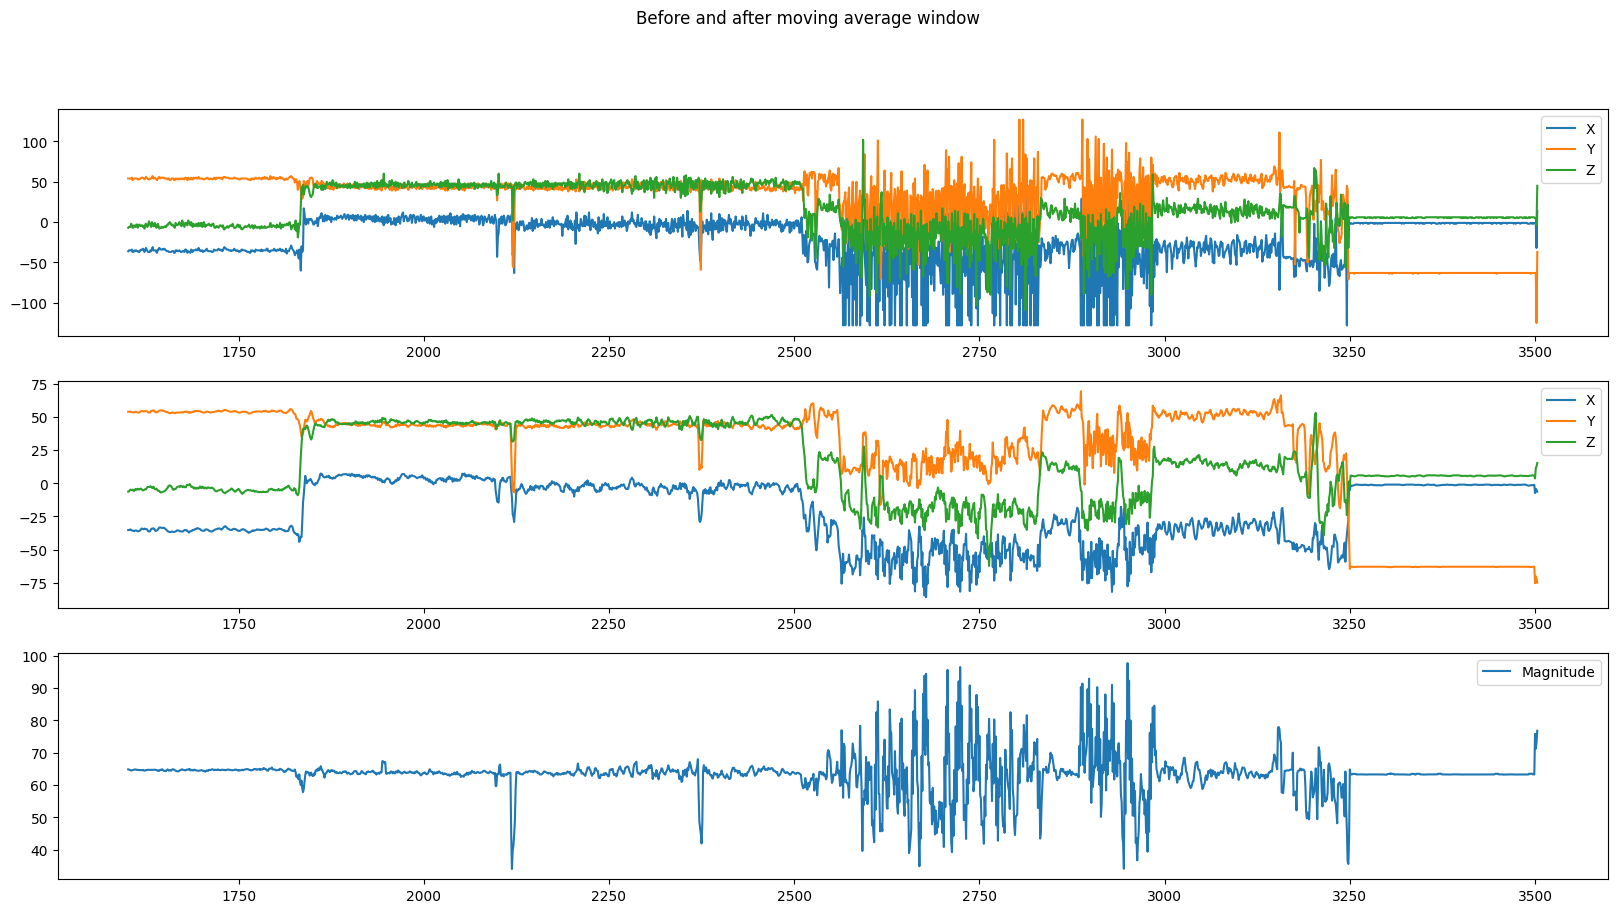

: 

In [9]:
# Central moving average window of 1 minute
def central_moving_average(data, window_size, plot=False, person=None):
    # If plot, plot the data before and after moving average
    if plot:
        plt.figure()
        plt.plot(data['X'], label='X')
        plt.plot(data['Y'], label='Y')
        plt.plot(data['Z'], label='Z')
        plt.xlabel('Time [s]')
        plt.ylabel('Acceleration [g]')
        plt.legend()
        if person:
            plt.title(f'E4 Acceleration Data for person {person}')
        else:
            plt.title('E4 Acceleration Data')
        plt.show()
    data['X'] = data['X'].rolling(window=window_size, min_periods=1, center=True).mean()
    data['Y'] = data['Y'].rolling(window=window_size, min_periods=1, center=True).mean()
    data['Z'] = data['Z'].rolling(window=window_size, min_periods=1, center=True).mean()
    first = lambda x: x.iloc[0]
    # data = data.rolling(window=window_size, min_periods=10).agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean', 'Time[s]': first})
    if plot:
        plt.figure()
        plt.plot(data['X'], label='X MAW')
        plt.plot(data['Y'], label='Y MAW')
        plt.plot(data['Z'], label='Z MAW')
        plt.xlabel('Time [s]')
        plt.ylabel('Acceleration [g]')
        plt.legend()
        if person:
            plt.title(f'E4 Acceleration Data for person {person} after moving average window')
        else:
            plt.title('E4 Acceleration Data after moving average window')
        plt.show()
    return data

def compute_ACC_magnitude(data):
    return np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

e4_data, VO2_data = sync_acc_with_VO2(10)
import copy
e4_data_maw = copy.deepcopy(e4_data)
e4_data_maw = central_moving_average(e4_data_maw, 5)
e4_data_mag = compute_ACC_magnitude(e4_data_maw)
e4_data_maw['Magnitude'] = e4_data_mag
# Plot both side by side
fig, axs = plt.subplots(3, figsize=(20, 10))
fig.suptitle('Before and after moving average window')
axs[0].plot(e4_data['X'], label='X')
axs[0].plot(e4_data['Y'], label='Y')
axs[0].plot(e4_data['Z'], label='Z')
axs[1].plot(e4_data_maw['X'], label='X')
axs[1].plot(e4_data_maw['Y'], label='Y')
axs[1].plot(e4_data_maw['Z'], label='Z')
axs[2].plot(e4_data_mag, label='Magnitude')
print(len(e4_data['X']), len(e4_data_maw['X']))
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

E4 start timestamp: 2021-12-03 16:57:36 
VO2 start timestamp: 2021-12-03 16:58:51
VO2 data starts 75.0 seconds after E4 data
E4 data length before cutting:  2289
E4 data length after cutting:  2214


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


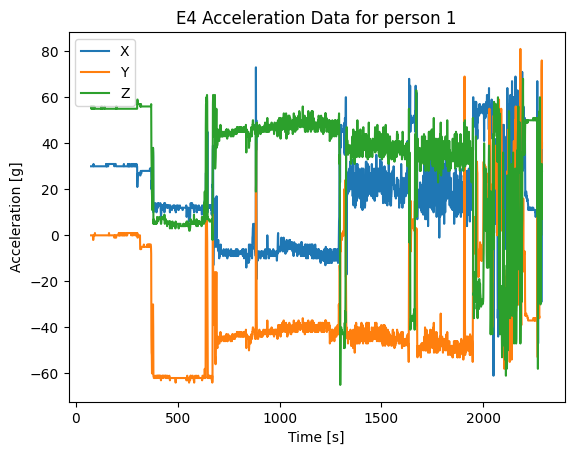

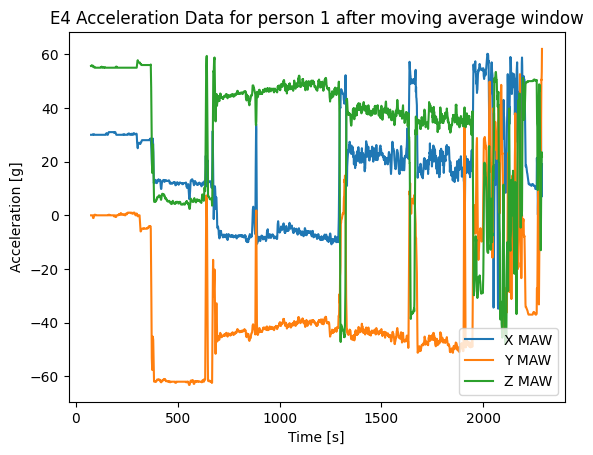

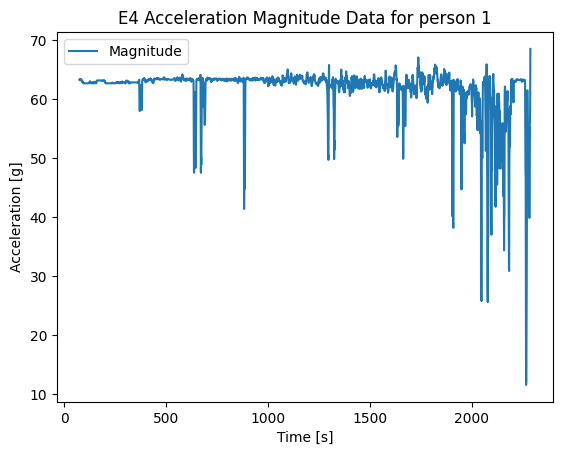

E4 start timestamp: 2021-11-25 16:57:36 
VO2 start timestamp: 2021-11-25 17:17:43
VO2 data starts 1207.0 seconds after E4 data
E4 data length before cutting:  3989
E4 data length after cutting:  2782


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


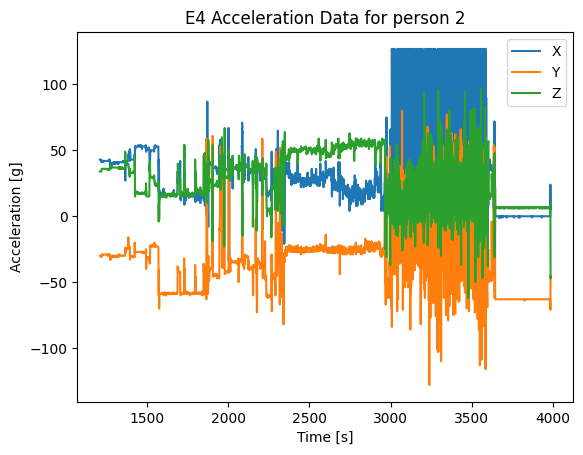

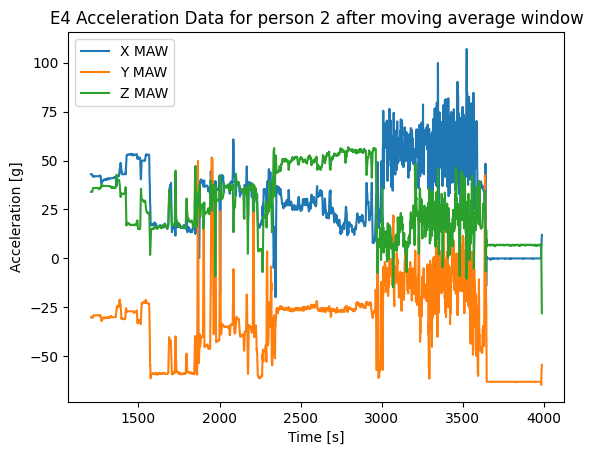

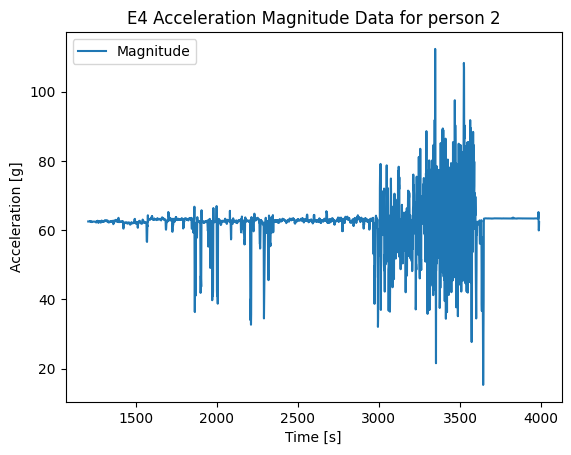

E4 start timestamp: 2021-11-26 16:08:32 
VO2 start timestamp: 2021-11-26 16:20:27
VO2 data starts 715.0 seconds after E4 data
E4 data length before cutting:  3653
E4 data length after cutting:  2938


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


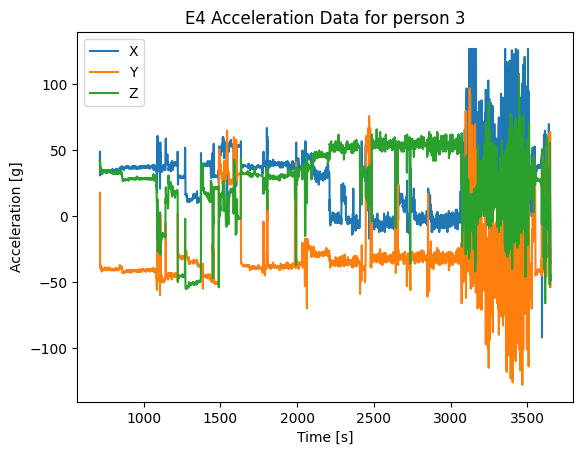

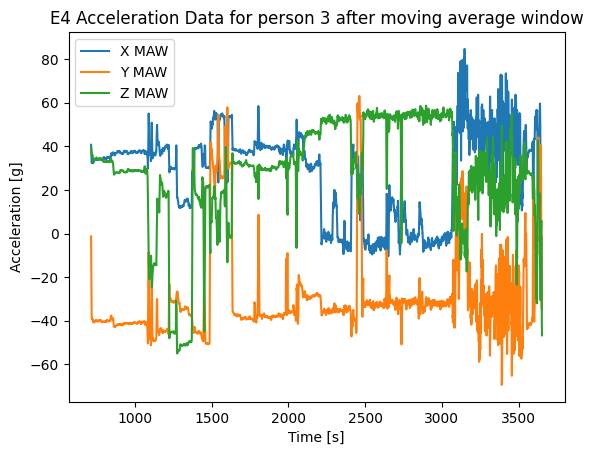

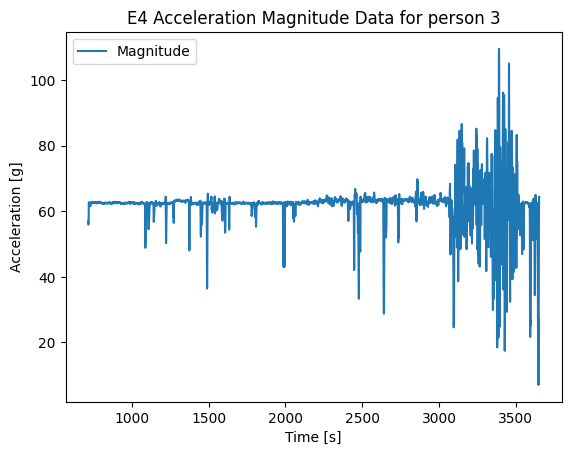

E4 start timestamp: 2021-11-26 17:48:48 
VO2 start timestamp: 2021-11-26 18:15:49
VO2 data starts 1621.0 seconds after E4 data
E4 data length before cutting:  3950
E4 data length after cutting:  2329


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


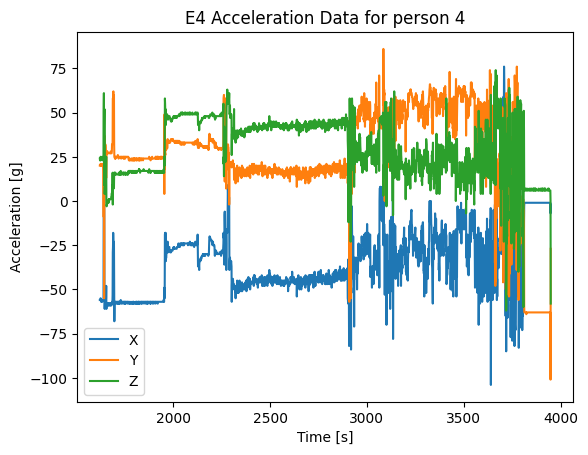

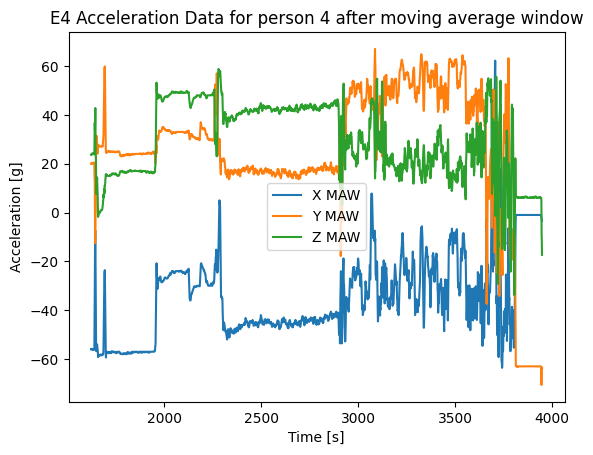

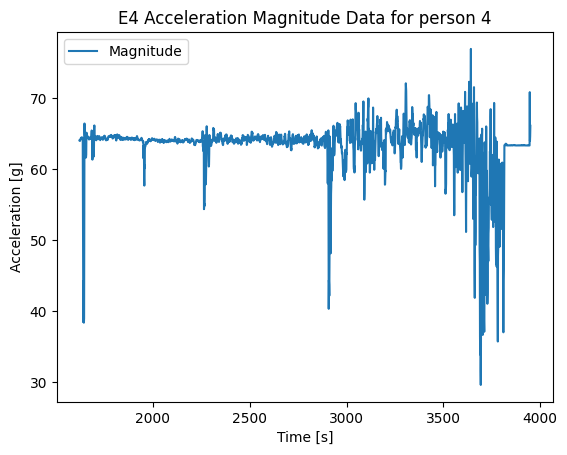

E4 start timestamp: 2021-11-29 09:18:56 
VO2 start timestamp: 2021-11-29 09:40:48
VO2 data starts 1312.0 seconds after E4 data
E4 data length before cutting:  3440
E4 data length after cutting:  2128


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


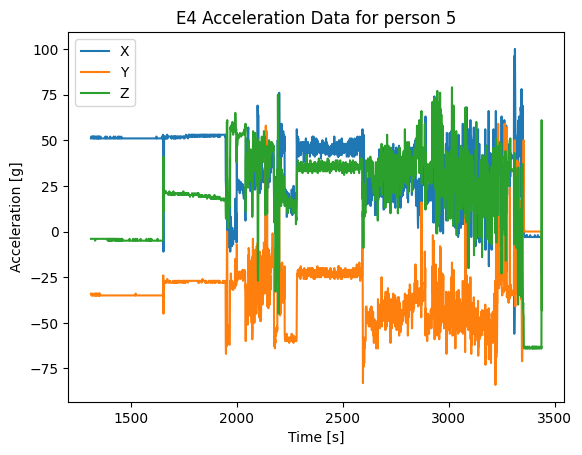

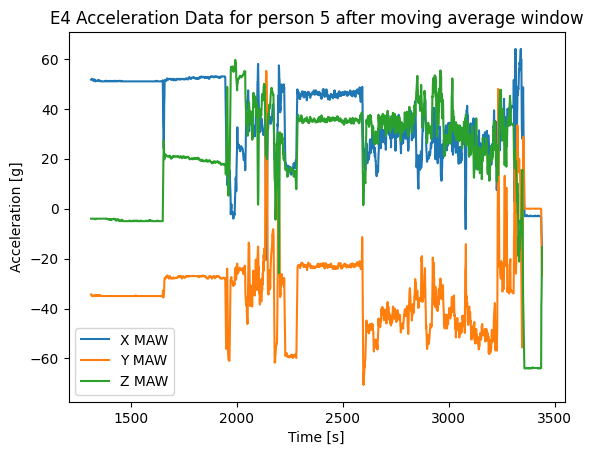

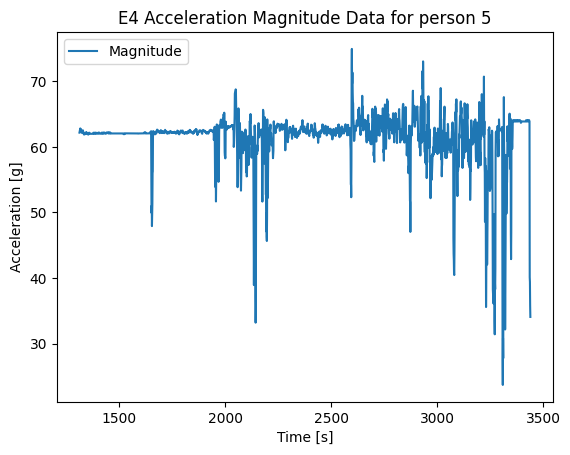

E4 start timestamp: 2021-11-29 10:25:04 
VO2 start timestamp: 2021-11-29 10:37:55
VO2 data starts 771.0 seconds after E4 data
E4 data length before cutting:  2901
E4 data length after cutting:  2130


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


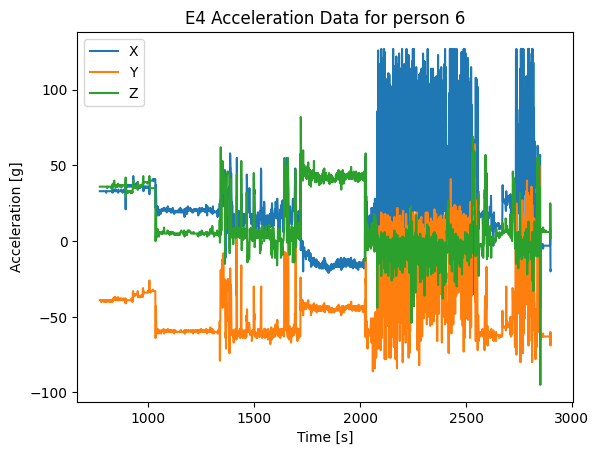

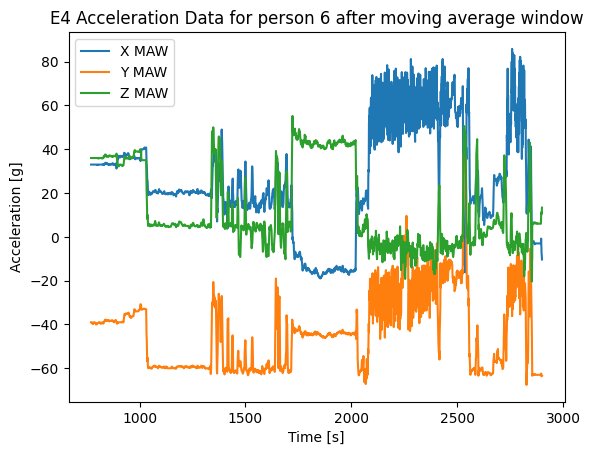

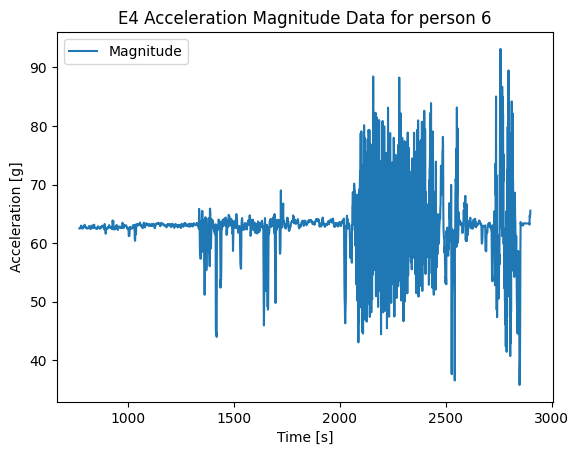

E4 start timestamp: 2021-11-29 15:19:28 
VO2 start timestamp: 2021-11-29 15:33:03
VO2 data starts 815.0 seconds after E4 data
E4 data length before cutting:  3003
E4 data length after cutting:  2188


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


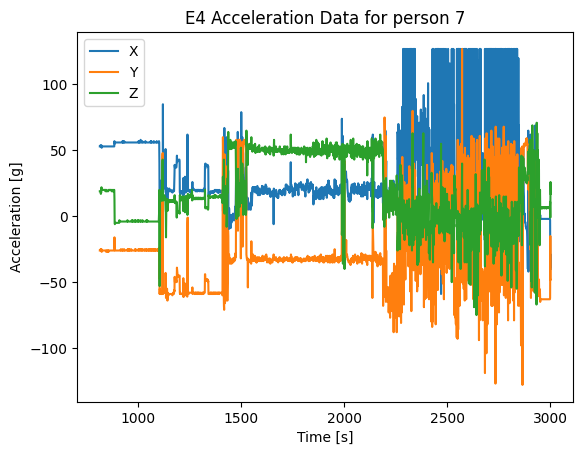

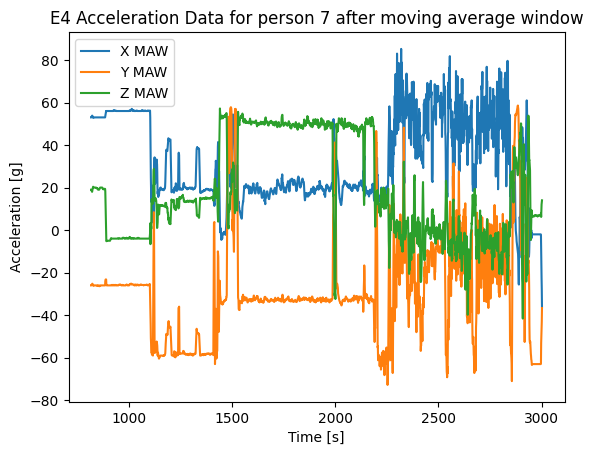

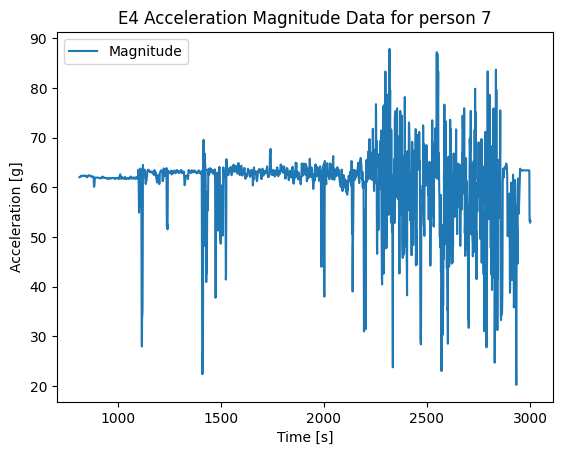

E4 start timestamp: 2021-11-29 17:40:16 
VO2 start timestamp: 2021-11-29 18:00:32
VO2 data starts 1216.0 seconds after E4 data
E4 data length before cutting:  3108
E4 data length after cutting:  1892


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


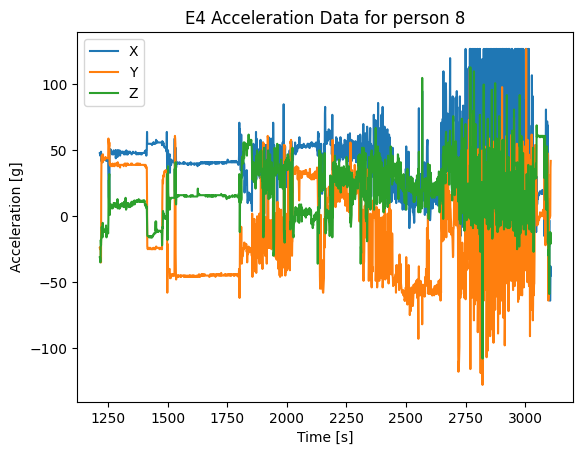

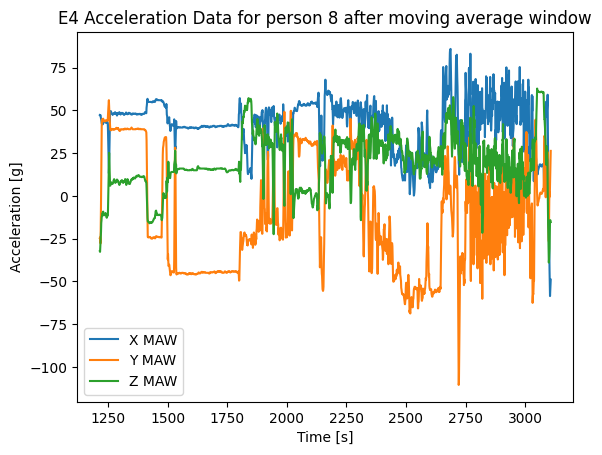

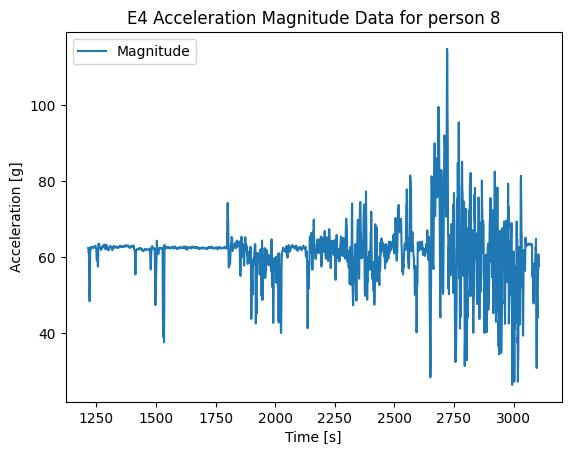

E4 start timestamp: 2021-11-30 09:10:24 
VO2 start timestamp: 2021-11-30 09:19:13
VO2 data starts 529.0 seconds after E4 data
E4 data length before cutting:  2463
E4 data length after cutting:  1934


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


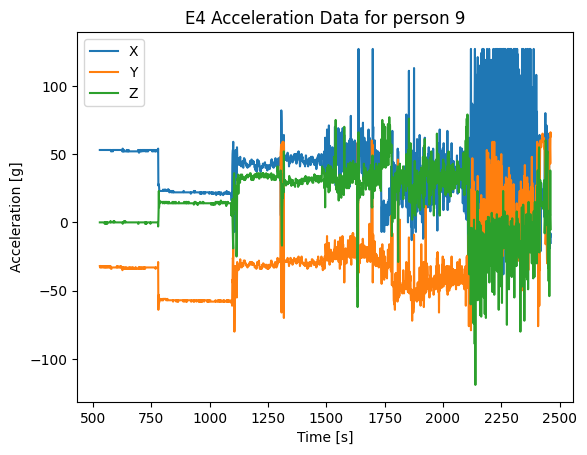

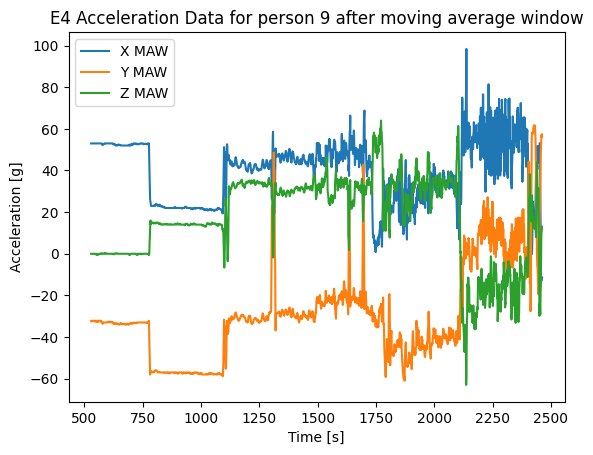

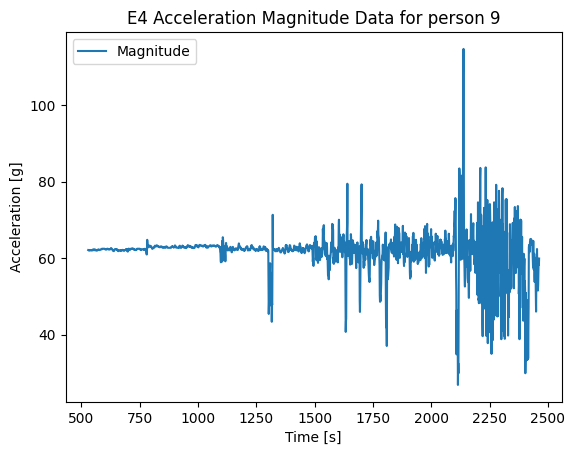

E4 start timestamp: 2021-11-30 11:14:08 
VO2 start timestamp: 2021-11-30 11:40:49
VO2 data starts 1601.0 seconds after E4 data
E4 data length before cutting:  3504
E4 data length after cutting:  1903


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


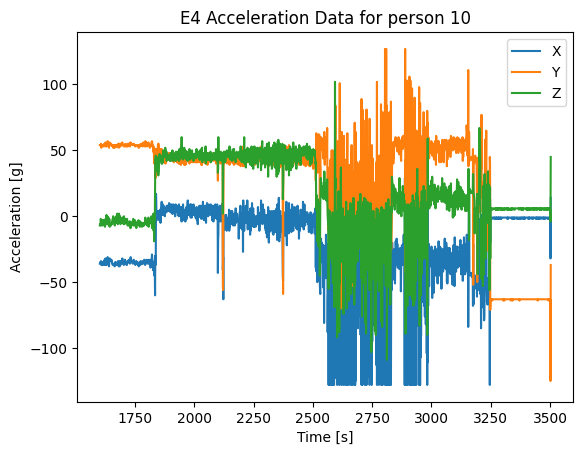

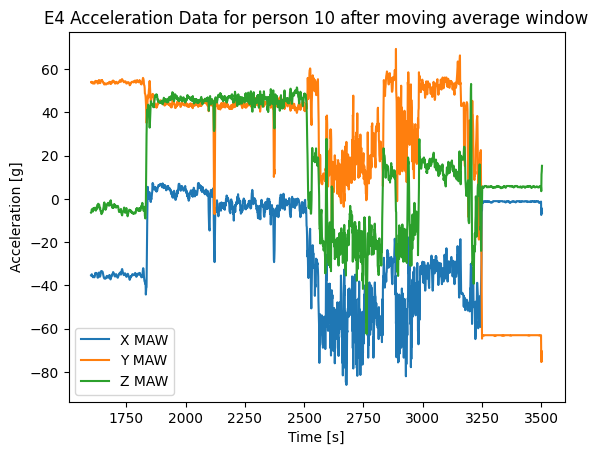

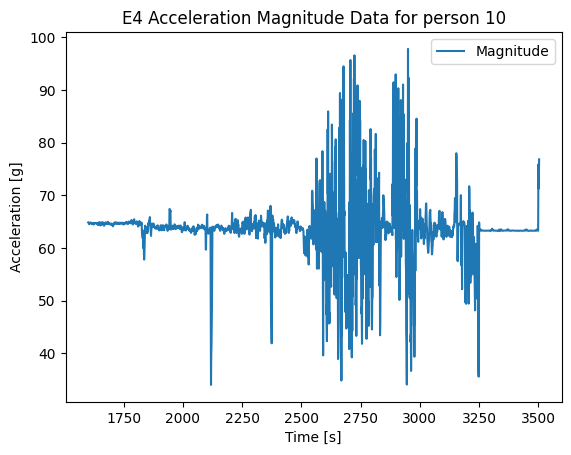

E4 start timestamp: 2021-11-30 14:36:48 
VO2 start timestamp: 2021-11-30 15:21:53
VO2 data starts 2705.0 seconds after E4 data
E4 data length before cutting:  4824
E4 data length after cutting:  2119


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


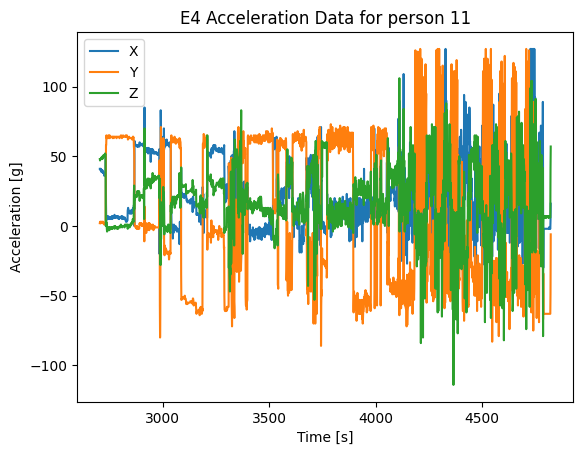

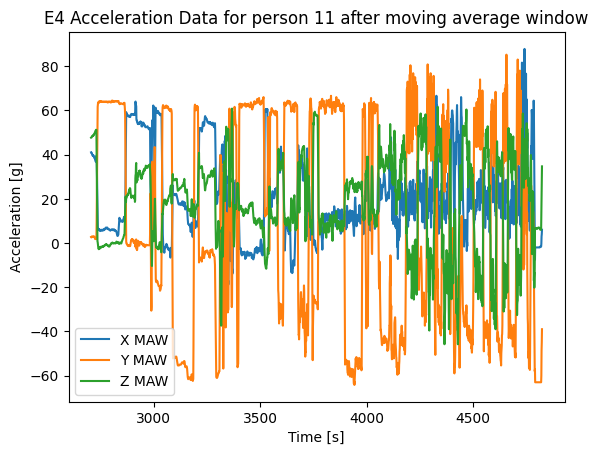

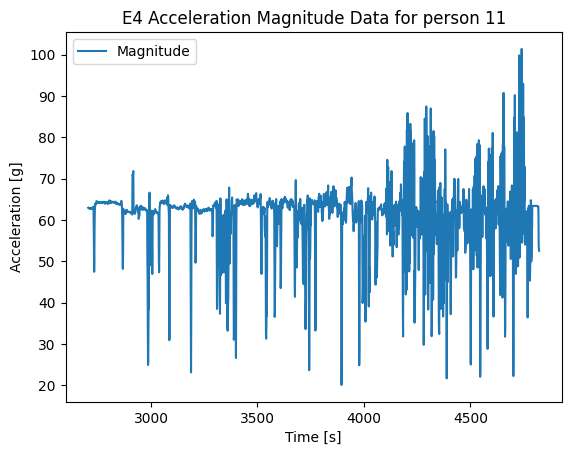

E4 start timestamp: 2021-12-03 10:27:12 
VO2 start timestamp: 2021-12-03 10:56:45
VO2 data starts 1773.0 seconds after E4 data
E4 data length before cutting:  4446
E4 data length after cutting:  2673


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


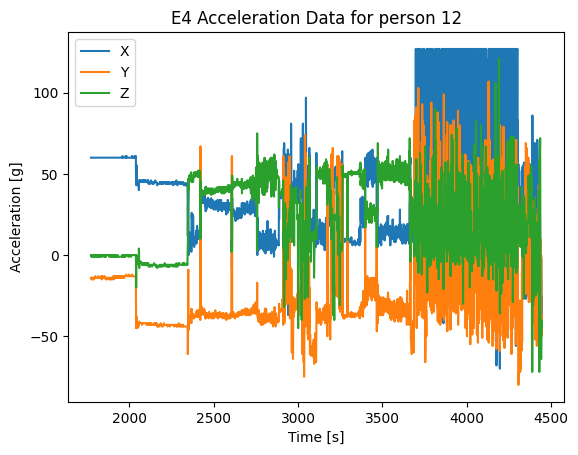

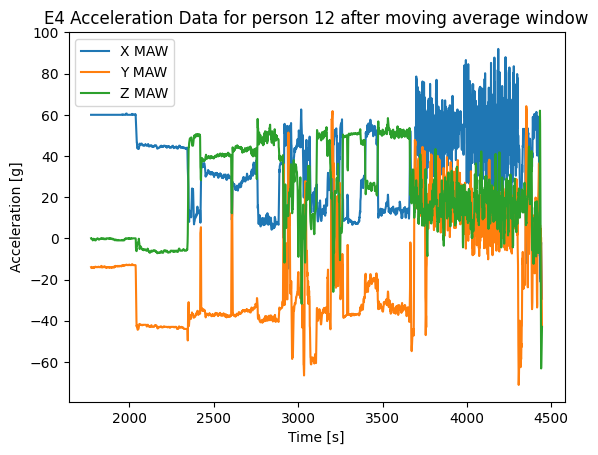

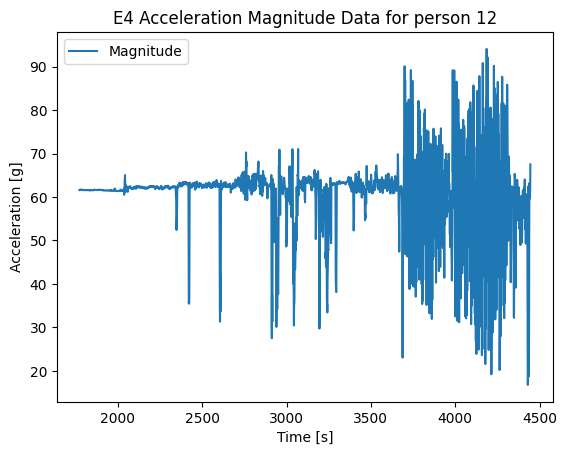

E4 start timestamp: 2021-11-30 18:20:48 
VO2 start timestamp: 2021-11-30 18:30:52
VO2 data starts 604.0 seconds after E4 data
E4 data length before cutting:  2644
E4 data length after cutting:  2040


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


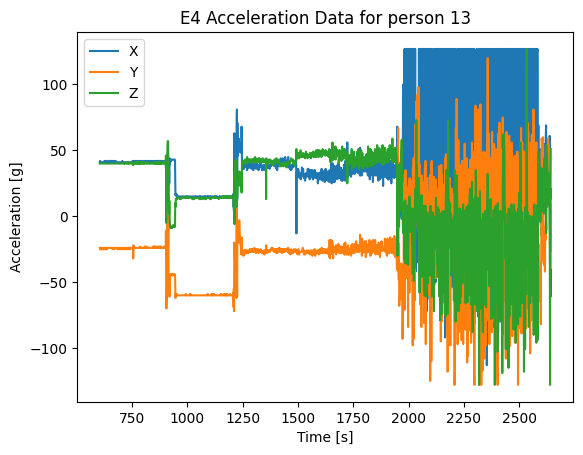

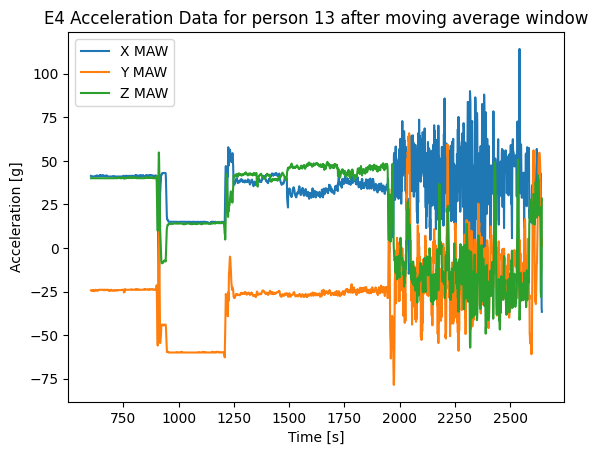

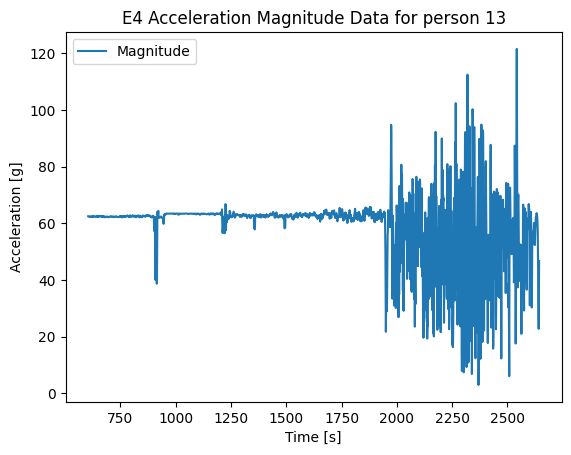

E4 start timestamp: 2021-12-01 15:10:56 
VO2 start timestamp: 2021-12-01 15:20:41
VO2 data starts 585.0 seconds after E4 data
E4 data length before cutting:  2777
E4 data length after cutting:  2192


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


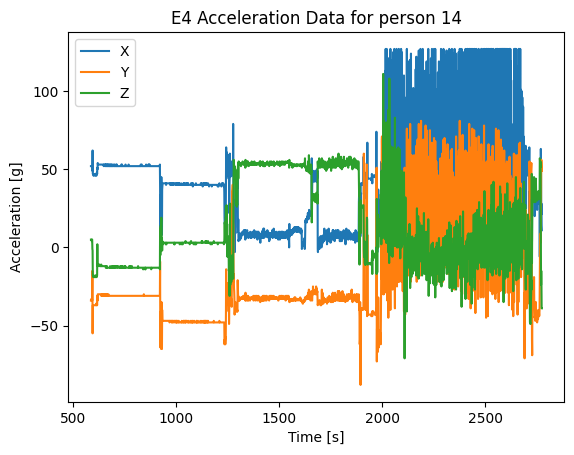

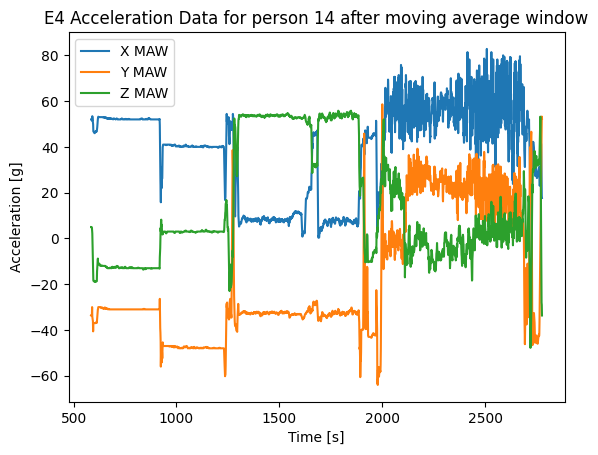

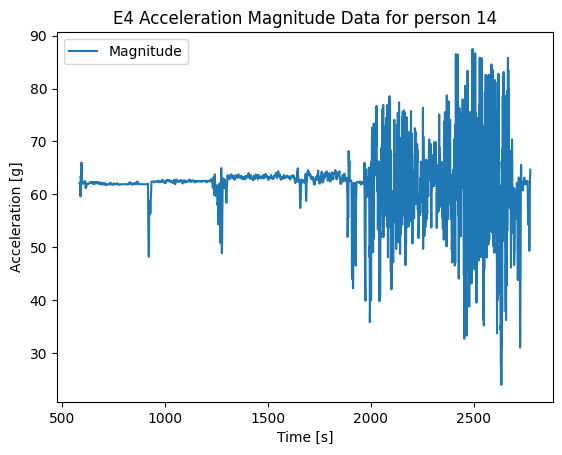

E4 start timestamp: 2021-12-01 10:48:32 
VO2 start timestamp: 2021-12-01 11:04:23
VO2 data starts 951.0 seconds after E4 data
E4 data length before cutting:  3286
E4 data length after cutting:  2335


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


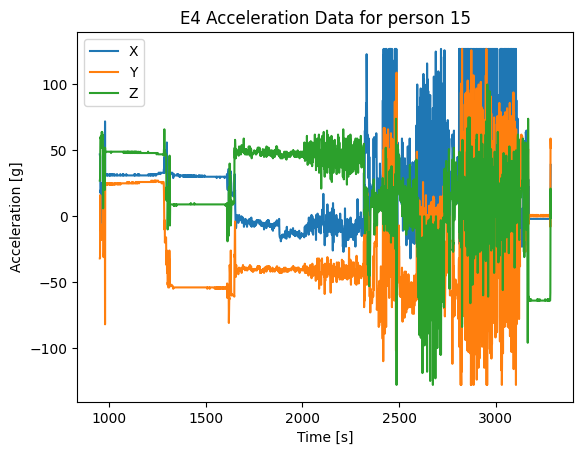

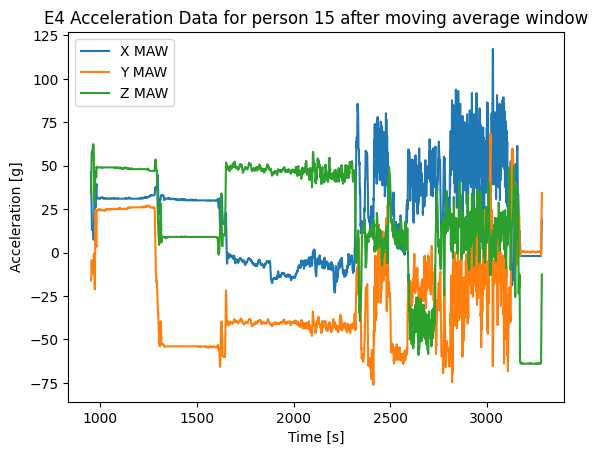

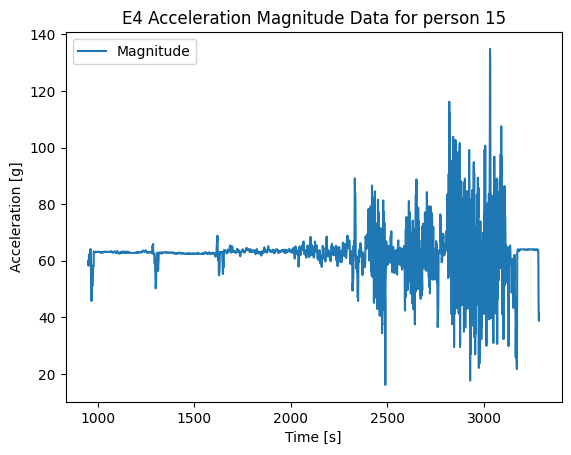

E4 start timestamp: 2021-12-01 18:08:00 
VO2 start timestamp: 2021-12-01 18:44:37
VO2 data starts 2197.0 seconds after E4 data
E4 data length before cutting:  4747
E4 data length after cutting:  2550


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


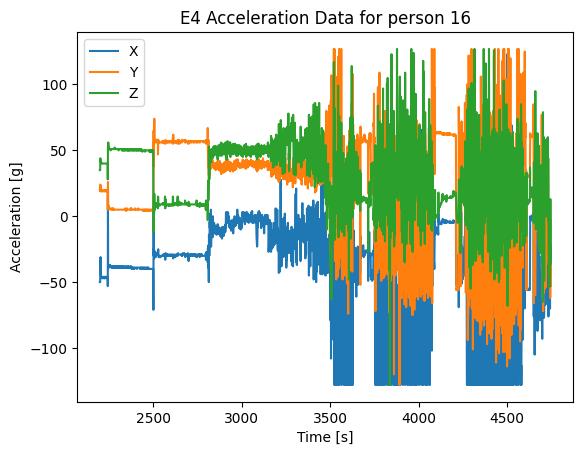

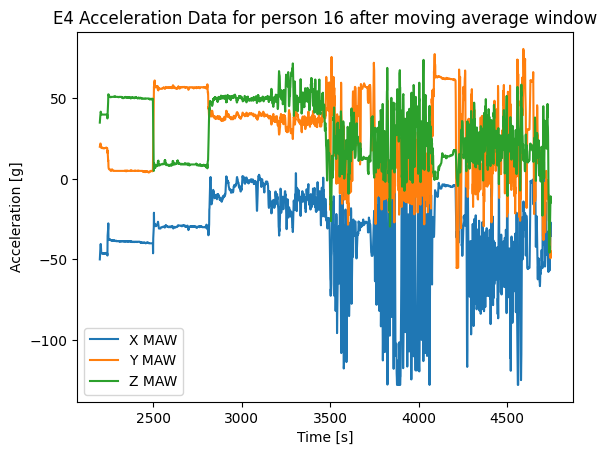

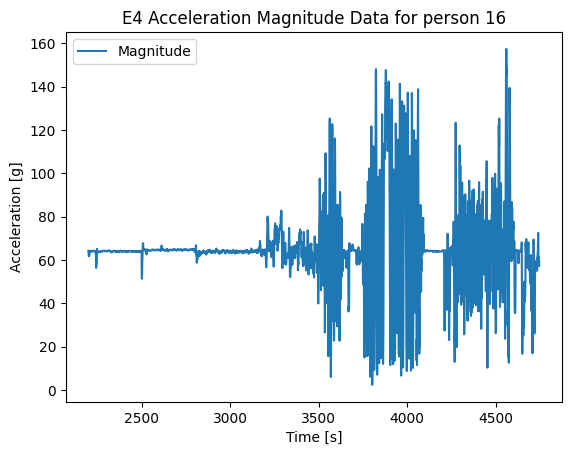

E4 start timestamp: 2021-12-02 16:32:00 
VO2 start timestamp: 2021-12-02 17:04:07
VO2 data starts 1927.0 seconds after E4 data
E4 data length before cutting:  4217
E4 data length after cutting:  2290


C:\Users\tiitu\AppData\Local\Temp\ipykernel_42500\411797092.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


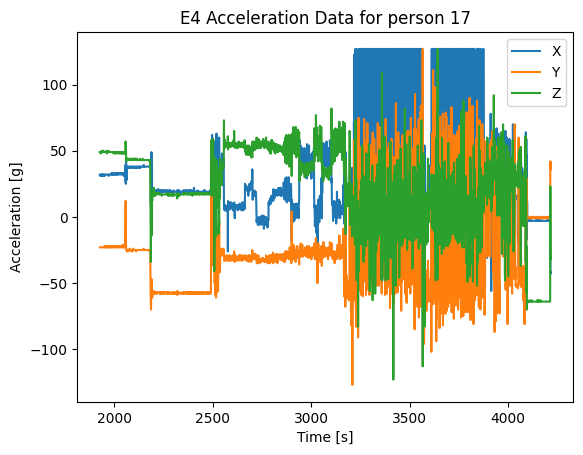

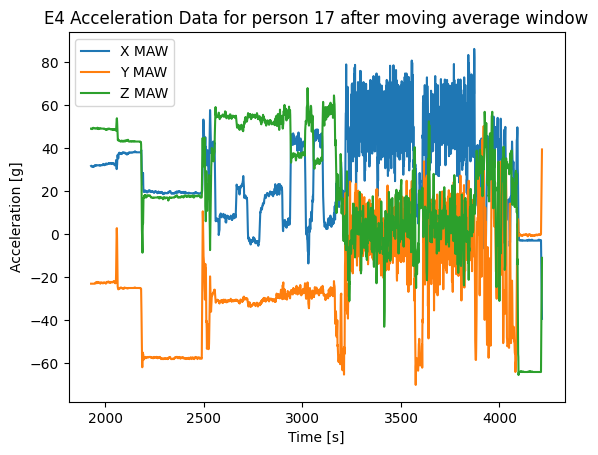

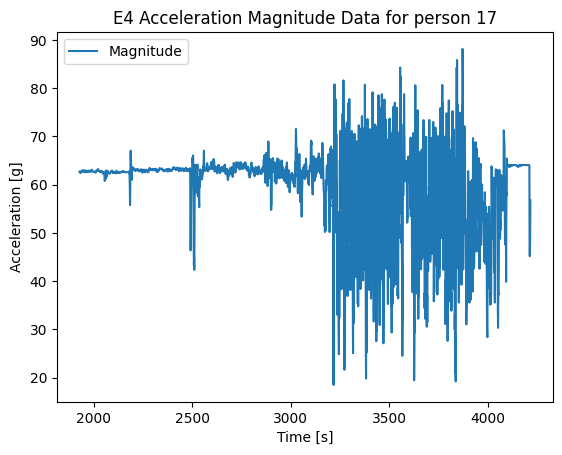

In [6]:
# Complete the ACC data preprocessing for all persons
preprocessed_data = []
for i in range(1, PERSONS+1):
    print("Progress: ", i, "/", PERSONS, end="\r")
    e4_data, VO2_data = sync_acc_with_VO2(i, handle_outliers=False)
    e4_data = central_moving_average(e4_data, 5, plot=True, person=i)
    e4_data_mag = compute_ACC_magnitude(e4_data)
    e4_data['Magnitude'] = e4_data_mag
    # Plot magnitude
    plt.figure()
    plt.plot(e4_data['Magnitude'], label='Magnitude')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [g]')
    plt.legend()
    plt.title(f'E4 Acceleration Magnitude Data for person {i}')
    plt.show()
    preprocessed_data.append(e4_data)

In [7]:
# Save the preprocessed data
for i, participant in enumerate(preprocessed_data):
    os.makedirs(f"preprocessed_dataset/P{i+1}", exist_ok=True)
    # Delete the file if it exists
    participant[['Time[s]','X', 'Y', 'Z', 'Magnitude']].to_pickle(f"preprocessed_dataset/P{i+1}/ACC_E4.pkl")